## 关于数据集 | About Dataset

### 内容 | Content

该数据集包含世界各地不同气象站每日记录的天气状况信息。信息包括降水量、降雪量、气温、风速，以及当天是否有雷暴或其他恶劣天气状况。

The dataset contains information on weather conditions recorded on each day at various weather stations around the world. Information includes precipitation, snowfall, temperatures, wind speed and whether the day included thunder storms or other poor weather conditions.


### 说明 | Description

- STA
  - 气象站 | Weather Station
- Date
- Precip
  - 降水量（毫米）| Precipitation (mm)
- MaxTemp
  - 最高温度（摄氏度）| Maximum temperature in degrees Celsius
  - -33.3 —— 50
- MinTemp
  - 最低温度（摄氏度）| Minimum temperature in degrees Celsius
  - -38.3 —— 34
- MeanTemp
  - 平均温度（摄氏度）| Mean temperature in degrees Celsius
- Snowfall
  - 降雪量（毫米）
- YR
  - 观测年份
- MO
  - 观测月份
- DA
  - 观测日
- MAX
  - 最高温度（华氏度）| Maximum temperature in degrees Fahrenheit
  - -28 —— 122
- MIN
  - 最低温度（华氏度）| Minimum temperature in degrees Fahrenheit
  - -37 —— 94
- MEAN
  - 平均温度（华氏度）| Mean temperature in degrees Fahrenheit
  - -32 —— 104

剩余的源数据列是缺失的，基本上可用的数据列只有以上列出的 | The remaining source data columns are missing, and basically, the only available data columns are those listed above.


---

这个项目来自 | This project is from 

https://www.kaggle.com/datasets/smid80/weatherww2/data?select = Summary+of+Weather.csv

---

## 复现

---

### 数据准备 | Data Preparation

---

In [10]:
import pandas as pd 
import numpy as np 
import matplotlib.pyplot as plt
from matplotlib.patches import Patch

import warnings
warnings.filterwarnings("ignore")


In [ ]:
df  =  pd.read_csv("SummaryOfWeather.csv")


In [ ]:
df.head().style.background_gradient(cmap  =  "viridis").hide(axis  =  "index")


STA,Date,Precip,WindGustSpd,MaxTemp,MinTemp,MeanTemp,Snowfall,PoorWeather,YR,MO,DA,PRCP,DR,SPD,MAX,MIN,MEA,SNF,SND,FT,FB,FTI,ITH,PGT,TSHDSBRSGF,SD3,RHX,RHN,RVG,WTE
10001,1942-7-1,1.016,nan,25.555556,22.222222,23.888889,0.000000,nan,42,7,1,0.04,nan,nan,78.000000,72.000000,75.000000,0.000000,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan
10001,1942-7-2,0,nan,28.888889,21.666667,25.555556,0.000000,nan,42,7,2,0,nan,nan,84.000000,71.000000,78.000000,0.000000,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan
10001,1942-7-3,2.54,nan,26.111111,22.222222,24.444444,0.000000,nan,42,7,3,0.1,nan,nan,79.000000,72.000000,76.000000,0.000000,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan
10001,1942-7-4,2.54,nan,26.666667,22.222222,24.444444,0.000000,nan,42,7,4,0.1,nan,nan,80.000000,72.000000,76.000000,0.000000,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan
10001,1942-7-5,0,nan,26.666667,21.666667,24.444444,0.000000,nan,42,7,5,0,nan,nan,80.000000,71.000000,76.000000,0.000000,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan


In [13]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 119040 entries, 0 to 119039
Data columns (total 31 columns):
 #   Column       Non-Null Count   Dtype  
---  ------       --------------   -----  
 0   STA          119040 non-null  int64  
 1   Date         119040 non-null  object 
 2   Precip       119040 non-null  object 
 3   WindGustSpd  532 non-null     float64
 4   MaxTemp      119040 non-null  float64
 5   MinTemp      119040 non-null  float64
 6   MeanTemp     119040 non-null  float64
 7   Snowfall     117877 non-null  object 
 8   PoorWeather  34237 non-null   object 
 9   YR           119040 non-null  int64  
 10  MO           119040 non-null  int64  
 11  DA           119040 non-null  int64  
 12  PRCP         117108 non-null  object 
 13  DR           533 non-null     float64
 14  SPD          532 non-null     float64
 15  MAX          118566 non-null  float64
 16  MIN          118572 non-null  float64
 17  MEA          118542 non-null  float64
 18  SNF          117877 non-

In [11]:
def Missing_Values_Analysis(df):
    # Calculate missing values
    missing_data = df.isnull().sum()
    missing_df = pd.DataFrame({
        "Column": missing_data.index,
        "Missing_Count": missing_data.values,
        "Missing_Percentage": (missing_data.values / len(df) * 100).round(2)
    })

    # Create missing values visualization
    plt.figure(figsize = (12, 6))
    bars = plt.bar(missing_df["Column"], missing_df["Missing_Percentage"], 
                color = ["#ff0000" if p > 50 else "#009b49" if p > 10 else "#0082ff" for p in missing_df["Missing_Percentage"]])

    # Add value labels
    for bar, count in zip(bars, missing_df["Missing_Count"]):
        if count > 0:
            plt.text(bar.get_x() + bar.get_width()/2, bar.get_height() + 0.5, 
                    f"{count}", ha = "center", va = "bottom", fontsize = 8)

    # Set chart properties
    plt.title("Missing Values Analysis", fontsize = 14, fontweight = "bold")
    plt.xlabel("Columns")
    plt.ylabel("Missing Percentage (%)")
    plt.xticks(rotation = 45, ha = "right")
    plt.grid(axis = "y", alpha = 0.3)

    # Add legend
    legend_elements  =  [
        Patch(facecolor = "#0082ff", label = "Low Missing (<10%)"),
        Patch(facecolor = "#009b49", label = "Medium Missing (10-50%)"),
        Patch(facecolor = "#ff0000", label = "High Missing (>50%)")
    ]
    plt.legend(handles = legend_elements, loc = "upper left")

    plt.tight_layout()
    plt.show()

    # Display missing values statistics
    print("Missing Values Statistics:")
    print(missing_df.sort_values("Missing_Percentage", ascending = False))
    

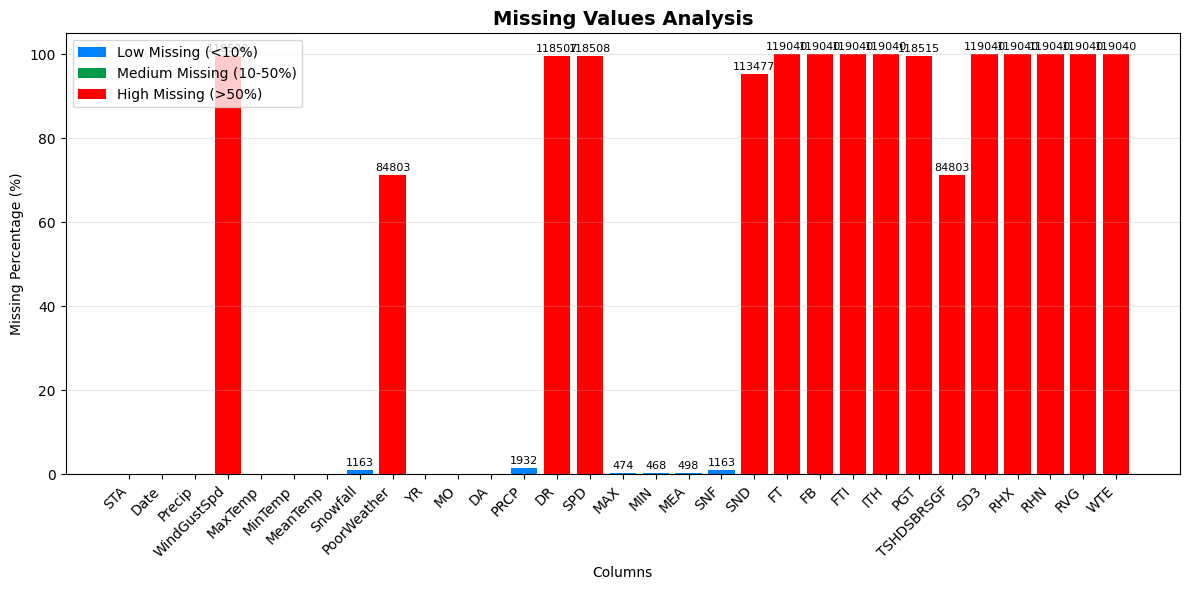

Missing Values Statistics:
         Column  Missing_Count  Missing_Percentage
26          SD3         119040              100.00
28          RHN         119040              100.00
27          RHX         119040              100.00
29          RVG         119040              100.00
20           FT         119040              100.00
22          FTI         119040              100.00
30          WTE         119040              100.00
23          ITH         119040              100.00
21           FB         119040              100.00
24          PGT         118515               99.56
3   WindGustSpd         118508               99.55
14          SPD         118508               99.55
13           DR         118507               99.55
19          SND         113477               95.33
8   PoorWeather          84803               71.24
25   TSHDSBRSGF          84803               71.24
12         PRCP           1932                1.62
18          SNF           1163                0.98
7   

In [12]:
Missing_Values_Analysis(df)


In [14]:
df = df[["MaxTemp", "MinTemp"]]


In [15]:
df.head().style.background_gradient(cmap = "viridis").hide(axis = "index")


MaxTemp,MinTemp
25.555556,22.222222
28.888889,21.666667
26.111111,22.222222
26.666667,22.222222
26.666667,21.666667


--- 

### 数据探索 | Data Exploration

---

In [21]:
def Data_Overview(df):
    # Simple data overview
    print("======================== DATASET OVERVIEW ==========================")
    print(f"Shape: {df.shape}")
    print(f"Memory usage: {df.memory_usage(deep = True).sum() / 1024 ** 2:.2f} MB")

    print("\n======================== DATA TYPES ==========================")
    print(df.dtypes)

    print("\n======================== MISSING VALUES ==========================")
    missing = df.isnull().sum()
    print(missing[missing > 0])

    print("\n======================== NUMERICAL SUMMARY ==========================")
    print(df.describe())

    print("\n======================== FIRST FEW ROWS ==========================")
    print(df.head())
    

In [22]:
Data_Overview(df)


======================== DATASET OVERVIEW ==========================
Shape: (119040, 2)
Memory usage: 1.82 MB

======================== DATA TYPES ==========================
MaxTemp    float64
MinTemp    float64
dtype: object

======================== MISSING VALUES ==========================
Series([], dtype: int64)

======================== NUMERICAL SUMMARY ==========================
             MaxTemp        MinTemp
count  119040.000000  119040.000000
mean       27.045111      17.789511
std         8.717817       8.334572
min       -33.333333     -38.333333
25%        25.555556      15.000000
50%        29.444444      21.111111
75%        31.666667      23.333333
max        50.000000      34.444444

======================== FIRST FEW ROWS ==========================
     MaxTemp    MinTemp
0  25.555556  22.222222
1  28.888889  21.666667
2  26.111111  22.222222
3  26.666667  22.222222
4  26.666667  21.666667
